In the Part 1 of this series on credit risk modelling, we will use logistic regression to create a model which will predict the probability of default by the borrowers. In Part 2, we will explore random forrest algorithm. Let's begin by importing all the required libraries:

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, classification_report, confusion_matrix

Load the dataset to a DataFrame and create a copy of it.

In [5]:
df = pd.read_csv("../data/credit.csv")
original_df = df.copy()

Let's have a look at the first 5 rows of our dataset.

In [6]:
df.head()

,age,income,home_ownership,job_length,loan_reason,amount,interest_rate,loan_status,loan_percent_income
0,26,232500,MORTGAGE,0.0,MEDICAL,25000,14.17,0,0.11
1,25,230000,MORTGAGE,5.0,MEDICAL,35000,13.99,0,0.15
2,23,83000,RENT,7.0,EDUCATION,25300,10.99,1,0.30
3,22,12600,MORTGAGE,NaN,PERSONAL,2000,5.42,1,0.16
4,25,12600,OWN,3.0,PERSONAL,1750,13.61,0,0.14


Some other basic information about the dataset.

In [7]:
df.shape

(32048, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32048 entries, 0 to 32047
Data columns (total 9 columns):
age                    32048 non-null int64
income                 32048 non-null int64
home_ownership         32048 non-null object
job_length             31159 non-null float64
loan_reason            32048 non-null object
amount                 32048 non-null int64
interest_rate          28989 non-null float64
loan_status            32048 non-null int64
loan_percent_income    32048 non-null float64
dtypes: float64(3), int64(4), object(2)
memory usage: 2.2+ MB


In [9]:
#loan_status of 1 is default and 0 for non default.
print(df['loan_status'].head())

0    0
1    0
2    1
3    1
4    0
Name: loan_status, dtype: int64


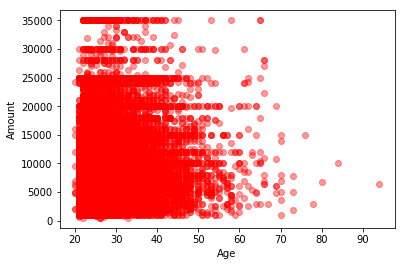

In [10]:
# Create the scatter plot for age and amount
plt.scatter(df['age'], df['amount'], c='red', alpha=0.4)
plt.xlabel("Age")
plt.ylabel("Amount")
plt.savefig('crm2.png')

## Handling missing data.

In [11]:
# Let us see which columns have null values:
print(df.columns[df.isnull().any()])

Index(['job_length', 'interest_rate'], dtype='object')


In [12]:
# Let's look at the missing values in the interest rate column:
display(df[df['interest_rate'].isnull()].head())

,age,income,home_ownership,job_length,loan_reason,amount,interest_rate,loan_status,loan_percent_income
6,24,41000,RENT,2.0,HOMEIMPROVEMENT,25000,NaN,1,0.61
12,24,225000,RENT,0.0,MEDICAL,6000,NaN,0,0.03
18,22,12996,OWN,1.0,EDUCATION,4750,NaN,1,0.37
50,22,54996,RENT,6.0,EDUCATION,25000,NaN,1,0.45
51,24,55000,RENT,4.0,HOMEIMPROVEMENT,25000,NaN,1,0.45


In [13]:
# Replace the missing values with the median value for all interest rates
df['interest_rate'].fillna((df['interest_rate'].median()), inplace=True)

In [14]:
display(df[df['interest_rate'].isnull()].head())

,age,income,home_ownership,job_length,loan_reason,amount,interest_rate,loan_status,loan_percent_income


## Remove missing data.

In [15]:
# Print the number of missing values in the job_length column.
display(df['job_length'].isnull().sum())

889

In [16]:
# Get the indices
ind = df[df['job_length'].isnull()].index

In [17]:
# Save the new dataset without missing values.
df_no_missing_data = df.drop(ind)

In [18]:
print(df_no_missing_data.columns[df_no_missing_data.isnull().any()])

Index([], dtype='object')


## One hot encoding.

In [19]:
# Create two data sets for numeric and non-numeric data
df_num = df_no_missing_data.select_dtypes(exclude=['object'])
df_str = df_no_missing_data.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
df_str_onehot = pd.get_dummies(df_str)

# Union the one-hot encoded columns to the numeric ones
df_loan_prep = pd.concat([df_num, df_str_onehot], axis=1)

# Print the columns in the new data set
display(df_loan_prep.columns)

Index(['age', 'income', 'job_length', 'amount', 'interest_rate', 'loan_status',
       'loan_percent_income', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'loan_reason_DEBTCONSOLIDATION', 'loan_reason_EDUCATION',
       'loan_reason_HOMEIMPROVEMENT', 'loan_reason_MEDICAL',
       'loan_reason_PERSONAL', 'loan_reason_VENTURE'],
      dtype='object')

## Building a Logistic Regression Model

We turn now to construct a logistic regression classifier. The form of the hypothesis $h_\theta(x)$ for logistic regression is:

$$h_\theta(x) = g(\theta^Tx)$$
  
where the function $g$ is the <b>sigmoid function</b>:

$$g(z) = \frac{1}{1+e^{-z}}$$

### Cost Function J$(\theta)$
The cost function for logistic regression is

$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m} \left(-y^{(i)} \log\left[h_{\theta}(x^{(i)})\right] - (1- y^{(i)}) \log\left[1-h_{\theta}(x^{(i)})\right]\right)$$

which can be rewritten as

$$J(\theta) = - \frac{1}{m} \left(\sum_{i=1}^{m} y^{(i)} \log\left[  h_{\theta}(x^{(i)})\right] + (1- y^{(i)}) \log\left[1-h_{\theta}(x^{(i)})\right] \right)$$

The gradient of this cost function is a vector which is the same length $n$ as $\theta$, where the $j$th element (for $j = 0,1,2,\ldots,n)$ is

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i = 1}^{m} \left(h_{\theta}(x^{(i)}) - y^{(i)}  \right) x^{(i)}_j$$
 

Here, we will use the `LogisticRegression` function from sklearn.

In [20]:
X = df_loan_prep.copy()
y = df_loan_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

# Train the logistic regression model on the training data
lr_classifier = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
predictions = lr_classifier.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
predictions_df = pd.DataFrame(predictions[:,1][0:5], columns = ['default_probability'])
real_df = y_test.head()


# Concatenate and print the two data frames for comparison
print(pd.concat([real_df.reset_index(drop = True),predictions_df], axis = 1))

   loan_status  default_probability
0            1             0.486872
1            0             0.028322
2            0             0.030441
3            1             0.453022
4            0             0.203535


In [21]:
# Create a dataframe for the probabilities of default
predictions_df = pd.DataFrame(predictions[:,1], columns = ['default_probability'])

# Reassign loan status based on the threshold
predictions_df['loan_status'] = predictions_df['default_probability'].apply(lambda x: 1 if x > 0.50 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, predictions_df['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.81      0.99      0.89      9796
     Default       0.74      0.14      0.24      2668

   micro avg       0.81      0.81      0.81     12464
   macro avg       0.77      0.56      0.56     12464
weighted avg       0.79      0.81      0.75     12464



In [22]:
# Print the accuracy score the model
print(lr_classifier.score(X_test, y_test))

0.8054396662387676


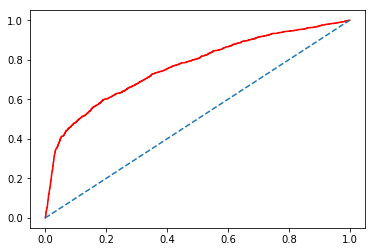

In [23]:
# Plot the ROC curve of the probabilities of default
prob_default = predictions[:, 1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, prob_default)
plt.plot(false_positive_rate, true_positive_rate, color = 'red')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.savefig('crm4.png')
plt.show()

In [24]:
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,predictions_df['loan_status']).ravel()
print(" Total Negative", tn, "\n False Positive", fp, "\n False Negative", fn, "\n Total Positive", tp)


 Total Negative 9660 
 False Positive 136 
 False Negative 2289 
 Total Positive 379
